# Quantitative Trading Strategyのデモ

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas_ta as ta
import backtrader as bt
import backtrader.analyzers as btanalyzers
import backtrader.feeds as btfeeds
import backtrader.strategies as btstrats
from IPython.display import display
from pandas_datareader import data as pdr

In [2]:
# 株価データの獲得
start = "2021-01-01"
end = "2021-12-31"
tickers = ['AAPL']
yf.pdr_override()
# yahooサイトからデータをダウンロード
df_apple = pdr.get_data_yahoo(tickers, start, end)
df_apple.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-23,175.850006,176.850006,175.270004,176.279999,174.288635,68356600
2021-12-27,177.089996,180.419998,177.070007,180.330002,178.292877,74919600
2021-12-28,180.160004,181.330002,178.529999,179.289993,177.264603,79144300
2021-12-29,179.330002,180.630005,178.139999,179.380005,177.353622,62348900
2021-12-30,179.470001,180.570007,178.089996,178.199997,176.186920,59773000


In [3]:
# Let's compute the 5-d, 15-d and 25-d SMA for visualization
df_apple["5d_sma_price"] = df_apple['Close'].rolling(5).mean()
df_apple["15d_sma_price"] = df_apple['Close'].rolling(15).mean()
df_apple["25d_sma_price"] = df_apple['Close'].rolling(25).mean()

# The 25-d SMA for trading volume
df_apple["25d_sma_volume"] = df_apple['Volume'].rolling(25).mean()
df_apple = df_apple[df_apple["25d_sma_price"].notna()]
df_apple.head()

,Open,High,Low,Close,Adj Close,Volume,5d_sma_price,15d_sma_price,25d_sma_price,25d_sma_volume
Date,,,,,,,,,,
2021-02-08,136.029999,136.960007,134.919998,136.910004,134.735046,71297200,135.998001,136.474667,133.6732,110034488.0
2021-02-09,136.619995,137.880005,135.850006,136.009995,133.849335,76774200,136.201999,137.020000,133.9372,107373380.0
2021-02-10,136.479996,136.990005,134.399994,135.389999,133.239182,73046600,136.491998,137.244000,134.1124,106388648.0
2021-02-11,135.899994,136.389999,133.770004,135.130005,132.983307,64280000,136.039999,137.128001,134.4536,102756328.0
2021-02-12,134.350006,135.529999,133.690002,135.369995,133.219498,60145100,135.762000,136.881333,134.6316,100779004.0


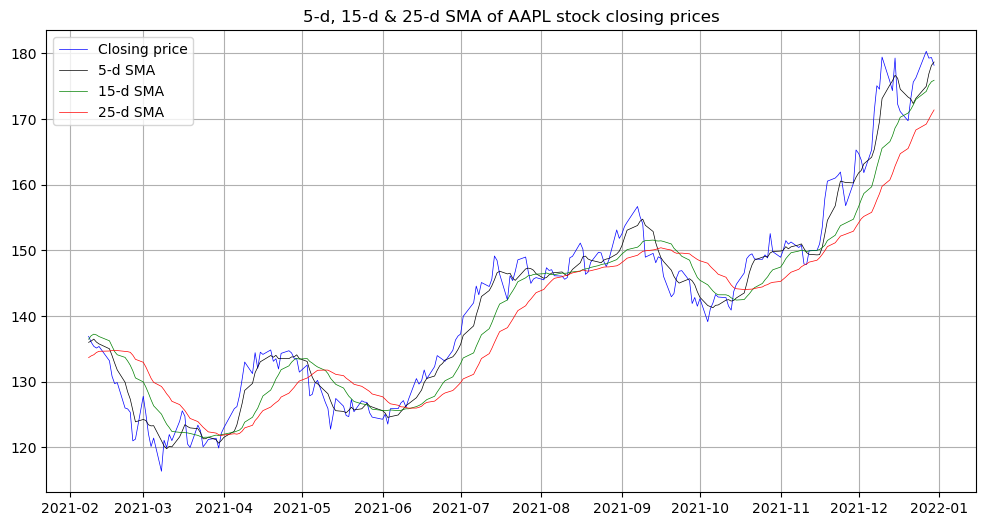

In [4]:
# Let's visualize the SMAs in a graph
plt.figure(figsize=(12, 6))
plt.plot(df_apple['Close'], color='blue', linewidth=0.5, label='Closing price')
plt.plot(df_apple['5d_sma_price'], color='black', linewidth=0.5, label='5-d SMA')
plt.plot(df_apple['15d_sma_price'], color='green', linewidth=0.5, label='15-d SMA')
plt.plot(df_apple['25d_sma_price'], color='red', linewidth=0.5, label='25-d SMA')
plt.title("5-d, 15-d & 25-d SMA of AAPL stock closing prices")
plt.legend(loc='best')
plt.grid()
plt.show()

In [5]:
# トレード情報のアナライザとして機能するTradeLoggerクラスの定義
class TradeLogger(bt.analyzers.Analyzer):
    """
    Analyzer returning closed trades information.
    """
    # アナライザの初期化
    def start(self):
        super(TradeLogger, self).start()

    # オブジェクトの初期化と空リストの作成
    def create_analysis(self):
        self.rets = []
        self.vals = dict()

    # トレードが閉じるたびに参照され、トレード情報が保存される
    def notify_trade(self, trade):
        """Receives trade notifications before each next cycle"""
        if trade.isclosed:
            self.vals = {'Date': self.strategy.datetime.datetime(),
                         'Gross PnL': round(trade.pnl, 2),
                         'Net PnL': round(trade.pnlcomm, 2),
                         'Trade commission': trade.commission,
                         'Trade duration (in days)': (trade.dtclose - trade.dtopen)
            }
            self.rets.append(self.vals)

    # 保存されたトレード情報を返す
    def get_analysis(self):
        return self.rets


In [6]:
# 与えられたデータと戦略でアナライザを実行する
def set_and_run(data, strategy, startcash, commission, stake):
    # Initialize cerebro engine, add the strategy and initial capital
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy)
    cerebro.adddata(data)
    cerebro.broker.setcash(startcash)
    print("Starting Portfolio Value: {}".format(cerebro.broker.getvalue()))

    # Set the broker commission
    cerebro.broker.setcommission(commission) 

    # Number of shares to buy/sell
    cerebro.addsizer(bt.sizers.FixedSize, stake=stake)

    # Add evaluation metrics
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, compression=1, factor=365, annualize=True)
    cerebro.addanalyzer(TradeLogger, _name="trade_logger")

    results = cerebro.run()
    print("Final Portfolio Value: {}".format(cerebro.broker.getvalue()))
    print("Sharpe Ratio: {}".format(results[0].analyzers.sharperatio.get_analysis()['sharperatio']))
    display(pd.DataFrame(results[0].analyzers.trade_logger.get_analysis()))

    plt.rcParams['figure.figsize'] = (16, 8)
    fig = cerebro.plot(barupfill=False,
                       bardownfill=False,
                       style='candle',
                       plotdist=0.5, 
                       volume=True,
                       barup='green',
                       valuetags=False,
                       subtxtsize=8)


In [7]:
# 最初の戦略クラスの定義
class FirstStrategy(bt.Strategy):
    params = (('close_period', 5),
              ('volume_period', 4)
    )

    # 指標の記述
    def __init__(self):
        self.close_sma = bt.indicators.SMA(self.data.close, period=self.params.close_period)
        self.volume_sma = bt.indicators.SMA(self.data.volume, period=self.params.volume_period)

    # 戦略の記述        
    def next(self):
        if not self.position:
            if self.data.close < self.close_sma and self.data.volume > self.volume_sma:
                self.buy()
        else:
            if self.data.close > self.close_sma and self.data.volume < self.volume_sma: 
                self.sell()

In [8]:
# Backtesting the model's parameters
cerebro = bt.Cerebro()
cerebro.adddata(data)
strats = cerebro.optstrategy(FirstStrategy,
                             close_period=range(2, 25), 
                             volume_period=range(2, 25))
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission) 
cerebro.addsizer(bt.sizers.FixedSize, stake=stake)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, factor=365)
cerebro.addanalyzer(bt.analyzers.VWR, timeframe=bt.TimeFrame.Days, tann=365)
results = cerebro.run()

df_result = pd.DataFrame([{"Close period": result[0].params.close_period, 
                           "Volume period": result[0].params.volume_period,
                           "Sharpe ratio": result[0].analyzers.sharperatio.get_analysis()['sharperatio'], 
                           "Variability weighted return (in %)": result[0].analyzers.vwr.get_analysis()['vwr']
                          } for result in results])
display(df_result.sort_values("Sharpe ratio", ascending=False))

NameError: name 'data' is not defined